In [ ]:
imUsingColab = False
shouldDownload = True # Set this to False after the first run to avoid redownloading the dataset
if shouldDownload:
  if imUsingColab:
    # Generate the .env file within the colab environment programatically
    file = open('.env','w') 
    file.write('KAGGLE_USERNAME=') # Populate this with your KAGGLE_USERNAME DO NOT COMMIT!!
    file.write('\nKAGGLE_KEY=') # Populate this with your KAGGLE api Key DO NOT COMMIT!!
    file.close()
    # Fetch the downloadData dependency 
    import urllib.request
    urllib.request.urlretrieve ("https://raw.githubusercontent.com/lihaojin/Movie_Data_Analysis/master/downloadData.py", "downloadData.py")

  import downloadData
  downloadData.download(imUsingColab)


In [ ]:
import datasets


In [ ]:
df = datasets.getMetadata()
df.head()

In [ ]:
df['movie_genres'].describe

In [ ]:
genreDict = {}
def genreCount(genres):
    for i in ast.literal_eval(genres):
        if(i in genreDict):
            genreDict[i] = genreDict[i] + 1
        else:
            genreDict[i] = 1
            
    

In [ ]:
genres = "['Animation', 'Comedy', 'Family','Animation', 'Comedy']"
genreCount(genres)
genreDict

In [ ]:
df['movie_genres'].apply(genreCount)

In [ ]:
words = "['Family', 'Animation', 'Romance', 'Comedy']"

In [ ]:
genreDict

In [ ]:
words

In [ ]:
words.split(',')

In [ ]:
import ast
words = ast.literal_eval(words)

In [ ]:
words

In [ ]:
for i in words:
    print(i)

In [ ]:
wordcloud = WordCloud(width=1050,height=900, background_color='white', 
                      max_words=1628,relative_scaling=0.7,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(genreDict)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [ ]:
import matplotlib.pyplot as plt


In [3]:
import graphs

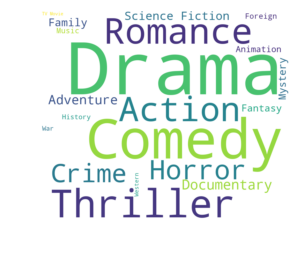

In [4]:
graphs.genreWordCloud()